In [ ]:
import numpy as np
import pandas as pd
import matplotlib as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import pathlib
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
from keras.models import Model
from tensorflow.keras import backend as K

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1213  100  1213    0     0   1550      0 --:--:-- --:--:-- --:--:--  1551


In [ ]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls
!ls PetImages

[kagglecatsanddogs_3367a.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of kagglecatsanddogs_3367a.zip or
        kagglecatsanddogs_3367a.zip.zip, and cannot find kagglecatsanddogs_3367a.zip.ZIP, period.
catanddogclassification  drive	kagglecatsanddogs_3367a.zip  sample_data
ls: cannot access 'PetImages': No such file or directory


In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

FileNotFoundError: [Errno 2] No such file or directory: 'PetImages/Cat'

In [ ]:
os.getcwd()

'/content'

## Getting a portion of data

In [ ]:
os.mkdir('PortionofData')

In [ ]:
os.chdir('PortionofData')

In [ ]:
os.getcwd()

'/content/PortionofData'

In [ ]:
os.mkdir('cat')
os.mkdir('dog')

In [ ]:
os.chdir("..")

In [ ]:
for c in random.sample(glob.glob('PetImages/Cat/*'), 1000):
    shutil.move(c, 'PortionofData/cat')

In [ ]:
for c in random.sample(glob.glob('PetImages/Dog/*'), 1000):
    shutil.move(c, 'PortionofData/dog')

In [ ]:
!ls PortionofData

cat  dog


In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PortionofData",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PortionofData",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.


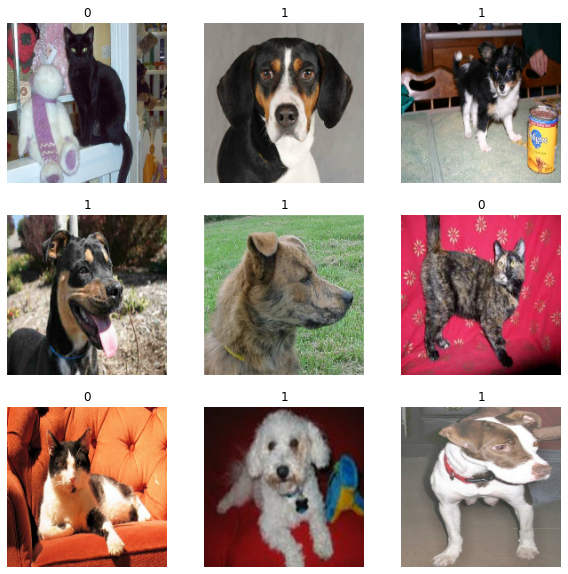

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

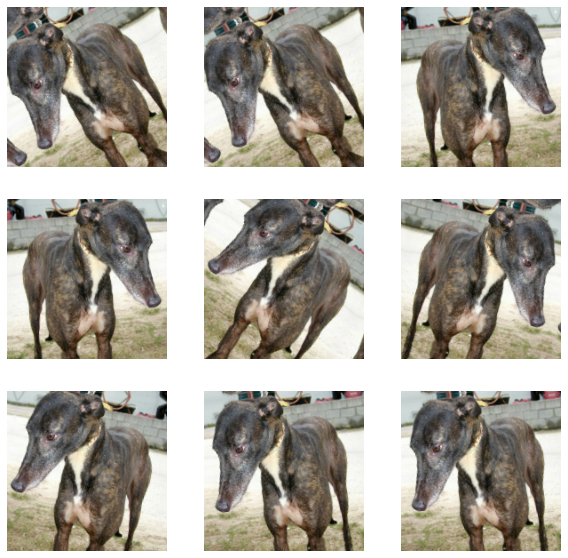

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Building the model

Tryings

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(180, 180, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 90, 90, 32)   896         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 45, 45, 64)   18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_11 (Flatten)           (None, 129600)       0           ['conv2d_3[0][0]']         

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(45 * 45 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((45, 45, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 129600)            388800    
                                                                 
 reshape_12 (Reshape)        (None, 45, 45, 64)        0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 90, 90, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 180, 180, 32)     18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 180, 180, 3)      867 

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),

        }

In [ ]:
vae = VAE(encoder, decoder)

In [ ]:
vae.summary()

ValueError: ignored

In [ ]:


epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
vae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
vae.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50


ValueError: ignored

TRYing


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense, Reshape, Conv2DTranspose, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np


class Autoencoder:
    """
    Autoencoder represents a Deep Convolutional autoencoder architecture with
    mirrored encoder and decoder components.
    """

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim):
        self.input_shape = input_shape # [28, 28, 1]
        self.conv_filters = conv_filters # [2, 4, 8]
        self.conv_kernels = conv_kernels # [3, 5, 3]
        self.conv_strides = conv_strides # [1, 2, 2]
        self.latent_space_dim = latent_space_dim # 2

        self.encoder = None
        self.decoder = None
        self.model = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None

        self._build()

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()

    def compile(self, learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        mse_loss = MeanSquaredError()
        self.model.compile(optimizer=optimizer, loss=mse_loss)

    def train(self, x_train, batch_size, num_epochs):
        self.model.fit(x_train,
                       x_train,
                       batch_size=batch_size,
                       epochs=num_epochs)

    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()

    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="autoencoder")

    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_conv_transpose_layers(self, x):
        """Add conv transpose blocks."""
        # loop through all the conv layers in reverse order and stop at the
        # first layer
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = self._add_conv_transpose_layer(layer_index, x)
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv2DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{layer_num}")(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv2DTranspose(
            filters=3,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
        return output_layer

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_conv_layers(self, encoder_input):
        """Create all convolutional blocks in encoder."""
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        """Add a convolutional block to a graph of layers, consisting of
        conv 2d + ReLU + batch normalization.
        """
        layer_number = layer_index + 1
        conv_layer = Conv2D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        """Flatten data and add bottleneck (Dense layer)."""
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        x = Dense(self.latent_space_dim, name="encoder_output")(x)
        return x

In [ ]:
autoencoder = Autoencoder(
    input_shape=(180, 180, 3),
    conv_filters=(32, 64, 64, 64),
    conv_kernels=(3, 3, 3, 3),
    conv_strides=(1, 2, 2, 1),
    latent_space_dim=2
)
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 180, 180, 3)]     0         
                                                                 
 encoder_conv_layer_1 (Conv2  (None, 180, 180, 32)     896       
 D)                                                              
                                                                 
 encoder_relu_1 (ReLU)       (None, 180, 180, 32)      0         
                                                                 
 encoder_bn_1 (BatchNormaliz  (None, 180, 180, 32)     128       
 ation)                                                          
                                                                 
 encoder_conv_layer_2 (Conv2  (None, 90, 90, 64)       18496     
 D)                                                              
                                                           

In [ ]:
from tensorflow.keras.datasets import mnist

LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 20


# def load_mnist():
#     (x_train, y_train), (x_test, y_test) = mnist.load_data()

#     x_train = x_train.astype("float32") / 255
#     x_train = x_train.reshape(x_train.shape + (1,))
#     x_test = x_test.astype("float32") / 255
#     x_test = x_test.reshape(x_test.shape + (1,))

#     return x_train, y_train, x_test, y_test


def train(x_train, learning_rate, batch_size, epochs):
    autoencoder = Autoencoder(
        input_shape=(180, 180, 3),
        conv_filters=(32, 64, 64, 64),
        conv_kernels=(3, 3, 3, 3),
        conv_strides=(1, 2, 2, 1),
        latent_space_dim=2
    )
    autoencoder.summary()
    autoencoder.compile(learning_rate)
    autoencoder.train(train_ds, batch_size, epochs)
    return autoencoder


if __name__ == "__main__":
    #x_train, _, _, _ = load_mnist()
    autoencoder = train(train_ds, LEARNING_RATE, BATCH_SIZE, EPOCHS)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 180, 180, 3)]     0         
                                                                 
 encoder_conv_layer_1 (Conv2  (None, 180, 180, 32)     896       
 D)                                                              
                                                                 
 encoder_relu_1 (ReLU)       (None, 180, 180, 32)      0         
                                                                 
 encoder_bn_1 (BatchNormaliz  (None, 180, 180, 32)     128       
 ation)                                                          
                                                                 
 encoder_conv_layer_2 (Conv2  (None, 90, 90, 64)       18496     
 D)                                                              
                                                           

ValueError: ignored

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
autoencoder.compile(
    # optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    # loss="binary_crossentropy",
    # metrics=["accuracy"],
)
# autoencoder.fit(
#     train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
# )

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense, Reshape, Conv2DTranspose, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np


class Autoencoder:
    """
    Autoencoder represents a Deep Convolutional autoencoder architecture with
    mirrored encoder and decoder components.
    """

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim):
        self.input_shape = input_shape # [28, 28, 1]
        self.conv_filters = conv_filters # [2, 4, 8]
        self.conv_kernels = conv_kernels # [3, 5, 3]
        self.conv_strides = conv_strides # [1, 2, 2]
        self.latent_space_dim = latent_space_dim # 2

        self.encoder = None
        self.decoder = None
        self.model = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None

        self._build()

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()

    def compile(self, learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        mse_loss = MeanSquaredError()
        self.model.compile(optimizer=optimizer, loss=mse_loss)

    def train(self, x_train, batch_size, num_epochs):
        self.model.fit(x_train,
                       x_train,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       shuffle=True)

    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()

    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="autoencoder")

    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_conv_transpose_layers(self, x):
        """Add conv transpose blocks."""
        # loop through all the conv layers in reverse order and stop at the
        # first layer
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = self._add_conv_transpose_layer(layer_index, x)
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv2DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{layer_num}")(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
        return output_layer

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_conv_layers(self, encoder_input):
        """Create all convolutional blocks in encoder."""
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        """Add a convolutional block to a graph of layers, consisting of
        conv 2d + ReLU + batch normalization.
        """
        layer_number = layer_index + 1
        conv_layer = Conv2D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        """Flatten data and add bottleneck (Dense layer)."""
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        x = Dense(self.latent_space_dim, name="encoder_output")(x)
        return x


In [ ]:
import os
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import tensorflow as tf


tf.compat.v1.disable_eager_execution()


class VAE:
    """
    VAE represents a Deep Convolutional variational autoencoder architecture
    with mirrored encoder and decoder components.
    """

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim):
        self.input_shape = input_shape # [28, 28, 1]
        self.conv_filters = conv_filters # [2, 4, 8]
        self.conv_kernels = conv_kernels # [3, 5, 3]
        self.conv_strides = conv_strides # [1, 2, 2]
        self.latent_space_dim = latent_space_dim # 2
        self.reconstruction_loss_weight = 1000

        self.encoder = None
        self.decoder = None
        self.model = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None

        self._build()

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()


    # def compile(self, learning_rate=0.0001):
    #     optimizer = Adam(learning_rate=learning_rate)
    #     self.model.compile(optimizer=optimizer,
    #                        loss=self._calculate_combined_loss,
    #                        metrics=[self._calculate_reconstruction_loss,
    #                                 self._calculate_kl_loss])

    def train(self, x_train, batch_size, num_epochs):
        self.model.fit(x_train,
                       x_train,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       shuffle=True)

    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def reconstruct(self, images):
        latent_representations = self.encoder.predict(images)
        reconstructed_images = self.decoder.predict(latent_representations)
        return reconstructed_images, latent_representations

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        autoencoder.load_weights(weights_path)
        return autoencoder

    def _calculate_combined_loss(self, y_target, y_predicted):
        reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
        kl_loss = self._calculate_kl_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss\
                                                         + kl_loss
        return combined_loss

    def _calculate_reconstruction_loss(self, y_target, y_predicted):
        error = y_target - y_predicted
        reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
        return reconstruction_loss

    def _calculate_kl_loss(self, y_target, y_predicted):
        kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) -
                               K.exp(self.log_variance), axis=1)
        return kl_loss

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)

    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()

    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="autoencoder")

    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_conv_transpose_layers(self, x):
        """Add conv transpose blocks."""
        # loop through all the conv layers in reverse order and stop at the
        # first layer
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = self._add_conv_transpose_layer(layer_index, x)
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv2DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{layer_num}")(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
        return output_layer

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_conv_layers(self, encoder_input):
        """Create all convolutional blocks in encoder."""
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        """Add a convolutional block to a graph of layers, consisting of
        conv 2d + ReLU + batch normalization.
        """
        layer_number = layer_index + 1
        conv_layer = Conv2D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        """Flatten data and add bottleneck with Guassian sampling (Dense
        layer).
        """
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        self.mu = Dense(self.latent_space_dim, name="mu")(x)
        self.log_variance = Dense(self.latent_space_dim,
                                  name="log_variance")(x)

    def sample_point_from_normal_distribution(args):
        mu, log_variance = args
        epsilon = K.random_normal(shape=K.shape(self.mu), mean=0.,
                                  stddev=1.)
        sampled_point = mu + K.exp(log_variance / 2) * epsilon
        return sampled_point

    x = Lambda(sample_point_from_normal_distribution,
                name="encoder_output")([self.mu, self.log_variance])
    return x


if __name__ == "__main__":
    autoencoder = VAE(
        input_shape=(28, 28, 1),
        conv_filters=(32, 64, 64, 64),
        conv_kernels=(3, 3, 3, 3),
        conv_strides=(1, 2, 2, 1),
        latent_space_dim=2
    )
    autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder_conv_layer_1 (Conv2D)  (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 encoder_relu_1 (ReLU)          (None, 28, 28, 32)   0           ['encoder_conv_layer_1[0][0]']   
                                                                                                  
 encoder_bn_1 (BatchNormalizati  (None, 28, 28, 32)  128         ['encoder_relu_1[0][0]']         
 on)                

In [ ]:
from tensorflow.keras.datasets import mnist

LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 20


def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype("float32") / 255
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.astype("float32") / 255
    x_test = x_test.reshape(x_test.shape + (1,))

    return x_train, y_train, x_test, y_test


def train(x_train, learning_rate, batch_size, epochs):
    autoencoder = Autoencoder(
        input_shape=(180, 180, 3),
        conv_filters=(32, 64, 64, 64),
        conv_kernels=(3, 3, 3, 3),
        conv_strides=(1, 2, 2, 1),
        latent_space_dim=2
    )
    autoencoder.summary()
    autoencoder.compile(learning_rate)
    autoencoder.train(x_train, batch_size, epochs)
    return autoencoder


if __name__ == "__main__":
    x_train, _, _, _ = load_mnist()
    autoencoder = train(x_train[:500], LEARNING_RATE, BATCH_SIZE, EPOCHS)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_layer_1 (Conv2  (None, 28, 28, 32)       320       
 D)                                                              
                                                                 
 encoder_relu_1 (ReLU)       (None, 28, 28, 32)        0         
                                                                 
 encoder_bn_1 (BatchNormaliz  (None, 28, 28, 32)       128       
 ation)                                                          
                                                                 
 encoder_conv_layer_2 (Conv2  (None, 14, 14, 64)       18496     
 D)                                                              
                                                           

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!git clone https://github.com/mpova/catanddogclassification.git

Cloning into 'catanddogclassification'...


In [ ]:
%cd repository_name

[Errno 2] No such file or directory: 'repository_name'
/content


In [ ]:
pwd

'/content'

In [ ]:
ls

catanddogclassification/  drive/  sample_data/
